
# Bayesian Optimization
# Optimizing the SGD Learning Rate when Training a Neural Network

### Roger Garriga
### Akhil Lohia
### Daniel Velasquez

# Introduction 


Training a neural network can be a difficult task. In particular, due to the large number of hyperparameters that need to be tunned, e.g. number of layers, number of hidden units, batch size among other. In this project, we focus on one particular hyperparameter that influence directly the success of the learning procedure: The stochastic gradient descent **learning rate **. We use bayesian optimization to tune the learning rate and compare the results with a grid search.

In [1]:
#Required libraries
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.gaussian_process import GaussianProcessRegressor
import pandas as pd
import math as mat
import scipy
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt
from tqdm import tqdm #add progress bar to for loops
import math

## Gaussian Process

In [2]:
def gaussian_kernel(x1,x2,noise,length): #Generate the kernel (cov) of the Gaussian Process
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    kernel = np.zeros((n1,n2))
    for i in range(n1):
        for j in range(n2):
            kernel[i,j] = noise**2*mat.exp(-0.5*((x1[i]-x2[j])/length)**2)
    return kernel


In [3]:
def LLH_GP(x,y,m,noise,length, sf = 0): #Compute the likelihood of the data (add sf if consider noise)
    ker = gaussian_kernel(x,x, noise, length)
    ker = ker+np.diag([sf]*len(x))
    return 1/2*(mat.log(np.linalg.det(ker))+np.dot(np.dot(np.transpose(y-m),
                                                       np.linalg.inv(ker)),(y-m)))


In [4]:
def opt_hyparams(x,y): #Find the hyperparameters that optimize LLH without noise
    ini = np.array([0,1,1])
    opt = optimize.minimize(lambda params: LLH_GP(x, y, params[0], params[1], params[2]),
                            ini)
    params = opt.x
    m = params[0]
    noise = abs(params[1])
    length = abs(params[2])
    sf = 0.001
    return m, noise, length, sf  

In [5]:
def opt_hyparams_noise(x,y): #Find the hyperparameters that optimize LLH with noise
    ini = np.array([0,1,1,1])
    opt = optimize.minimize(lambda params: LLH_GP(x, y, params[0], 
                                                  params[1], params[2], params[3]),ini)
    params = opt.x
    m = params[0]
    noise = abs(params[1])
    length = abs(params[2])
    sf = abs(params[3])
    return m, noise, length, sf

In [6]:
#Generates the mean and covariance of the posterior distribution in the given grid (xn) 
#from data (x,y) and the optimized parameters (mean->m, noise, length, noise in y -> sf)
def gp_posterior(x, y, xn, m, noise, length, sf = 0): 
    kxx = gaussian_kernel(x, x, noise = noise, length = length)
    kxxn = gaussian_kernel(x, xn, noise = noise, length = length)
    kxnx = gaussian_kernel(xn, x, noise = noise, length = length)
    kxnxn = gaussian_kernel(xn, xn, noise = noise, length = length)
    core = np.linalg.inv(kxx + np.diag([sf]*len(x)))
    En = np.dot(np.dot(kxnx, core), y)
    covn = kxnxn - np.dot(np.dot(kxnx, core), kxxn)  
    
    return En, covn

In [7]:
def data_posterior(x, E, cov):
    data = pd.DataFrame({'x': x})
    data['Mean'] = E
    data['StdDev'] = np.sqrt(np.diag(cov))
    #Generate the 5 samples as multivariate normals with 0 mean and covariance sigma
    for i in range(5):
        data['y'+str(i)] = np.random.multivariate_normal(E, cov)
    return data


# Neural Network Architecture and Dataset

Our goal is to perform classification on the MNIST dataset. To do so, we build a neural network with one hidden layer and a fixed number of hidden units. We divide the dataset in training and test sample. We define a function that trains the network as a function of the learning rate and returns a measure of accuracy estimated using the test sample. The accuracy corresponds the number of correctly classified observations divided by the total number of observations within the test sample. 

In [8]:
#MNIST dataset:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, validation_size=0)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
#placeholder:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

##Variables:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    #initial = tf.ones(shape)/10
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def neural_network(input, h_dim):
    W0 = weight_variable([784, h_dim])
    b0 = bias_variable([h_dim])
    h = tf.nn.relu(tf.matmul(input, W0) + b0)

    W = weight_variable([h_dim, 10])
    b = bias_variable([10])

    y = tf.nn.softmax(tf.matmul(h, W) + b)
    return y

#Network training:
def nn_train(learning_rate, h_dim, minibatch = 100):
    y = neural_network(x, h_dim)
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    #cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))*minibatch
    #train_step = tf.train.MomentumOptimizer(learning_rate, 0.5).minimize(cross_entropy)
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    #n_samples = len(mnist.train.images)
    
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    tf.global_variables_initializer().run()
    for i in range(10000+1):
        batch_xs, batch_ys = mnist.train.next_batch(minibatch) #These variables are numpy arrays
        
        if (i%20 == 0): #Training accuracy update
            a, c = sess.run([accuracy, cross_entropy], {x: batch_xs, y_: batch_ys})
            #print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c) + " (lr:" + str(learning_rate) + ")")
        
        if (i%100 == 0): #Test accuracy update
            a, c = sess.run([accuracy, cross_entropy], {x: mnist.test.images, y_: mnist.test.labels})
            #print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))

        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})


    return(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))


# Network training with variable learning rate

def nn_train_var(min_lr, max_lr, h_dim, minibatch = 100):
    
    # variable learning rate
    lr = tf.placeholder(tf.float32)
    
    y = neural_network(x, h_dim)
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    #cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))*minibatch
    
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # training step, the learning rate is a placeholder
    train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy)
    #train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
    
    tf.global_variables_initializer().run()
    
    for i in range(10000+1):
        # learning rate decay
        decay_speed = 2000.0
        learning_rate = min_lr + (max_lr - min_lr) * math.exp(-i/decay_speed)
        batch_xs, batch_ys = mnist.train.next_batch(minibatch) #These variables are numpy arrays
        
        if (i%20 == 0):
            a, c = sess.run([accuracy, cross_entropy], {x: batch_xs, y_: batch_ys})
            #print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c) + " (lr:" + str(learning_rate) + ")")
        
        if (i%100 == 0):
            a, c = sess.run([accuracy, cross_entropy], {x: mnist.test.images, y_: mnist.test.labels})
            #print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))
        
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, lr:learning_rate})

    return(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

# Acquisition Function

We start with a gaussian prior on the hyperparameters. We define an acquisition function that allows us to select a new learning rate to test. In particular we use *Expected Improvement*. With each new value, we train the network and use the output (i.e. the classification accuracy) to update the prior density. Notice that in this case, we want maximize the accuracy. 

In [10]:
#Acquisition function

def acquisition_fun(x, y, xn, mean_vector, sigma_vector):
    x_best = x[np.argmax(y)]
    y_best = np.max(y)
    ind_cand = np.array([not any(abs(xi-x)<=0.00001) for xi in xn]) #Indicator of candidates
    gamma = (mean_vector[ind_cand] - y_best)/sigma_vector[ind_cand]
    af = (mean_vector[ind_cand] - y_best)* norm.cdf(gamma) + sigma_vector[ind_cand]*norm.pdf(gamma)

    x_next = xn[ind_cand][np.argmax(af)]
    return x_next


# Algorithm


Initially, we assume we only observe 2 potential learning rates and their corresponding accuracy. We implement an algorithm that, given some prior on the learning rate, at each iteration the acquisition function selects a new candidate learning rate, then trains the network and estimates the posterior density. The plots below shows inital observations, the mean and 1 standard deviation around the mean. 

When implementing the algorith we can assume that the observed accuracies contains noise or not. Given that in practice the classification accuracy of the neural network is not a deterministic function of the learning rate, we assume the observe values contain some noise. 

100%|██████████| 2/2 [00:54<00:00, 26.72s/it]


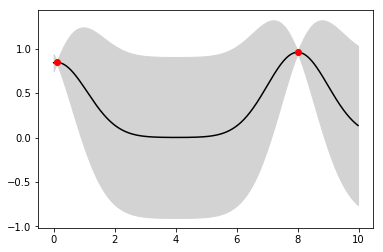

Initial Learning rates: [ 0.1  8. ]
Accuracy: [0.84670001, 0.96030003]


In [11]:

sess = tf.InteractiveSession()
h_dim = 100 # Fixed number of hidden dimensions
n = 500 # Number of point in the grid.
xn = np.arange(0,10,10/n)

l_rates = np.array([0.1,8]) # Initial learning rates
f = [nn_train(l, h_dim) for l in tqdm(l_rates)] #Accuracy

noise = 1;length =1; m=0
m, noise, length, sf = opt_hyparams(l_rates,f)
E, cov = gp_posterior(l_rates, f, xn, m, noise, length, sf)
data = data_posterior(xn, E, cov)

#This plot shows the mean and variance with two initial observations:
plt.plot(data['x'],data['Mean'], color = 'black', label = 'Mean')
plt.plot(l_rates,f, 'ro', label = 'Obs')
plt.fill_between(data['x'], data['Mean']-data['StdDev'], data['Mean']+data['StdDev'],color = 'lightgrey')
plt.show()

print ('Initial Learning rates:', l_rates)
print ('Accuracy:', f)

Now we perform 5 interations. The figure below exhibits the learning rates selected by the algorithm with their corresponding accuracies. Additionally it shows the new mean and 1 standard deviation around the mean. 

100%|██████████| 5/5 [02:29<00:00, 28.94s/it]


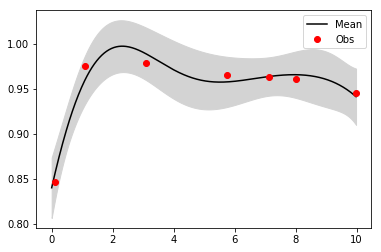

Initial Learning rates: [ 0.1   8.    7.14  1.1   5.76  3.1   9.98]
Accuracy: [ 0.84670001  0.96030003  0.96319997  0.97530001  0.9655      0.97869998
  0.9447    ]
CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 5.96 µs


In [12]:
#If sf is used, we have to use opt_hyparams_noise, otherwise use opt_hyparams. 
n_iter = 5

for i in tqdm(range(n_iter)):
    next_candidate = acquisition_fun(l_rates, f, xn, np.array(data['Mean']), np.array(data['StdDev']))
    l_rates = np.append(l_rates,next_candidate)
    f = np.append(f,nn_train(next_candidate, h_dim))
    E, cov = gp_posterior(l_rates, f, xn, m, noise, length, sf)
    data = data_posterior(xn, E, cov)

    try:
        m, noise, length, sf = opt_hyparams(l_rates,f)
    except ValueError:
        m, noise, length, sf = m, noise, length, sf


plt.plot(data['x'],data['Mean'], color = 'black', label = 'Mean')
plt.plot(l_rates,f, 'ro', label = 'Obs')
plt.fill_between(data['x'], data['Mean']-data['StdDev'], data['Mean']+data['StdDev'],color = 'lightgrey')

plt.legend()
plt.show()

print ('Initial Learning rates:', l_rates)
print ('Accuracy:', f)
%time

From the plot, we observe how the algorithm explores the domain of the hyperparameter, searching for the most appropiate learning rate. In this examples the initial learning rates are 0.1 and 8. After 5 interations the algorithm recomends a learning rate that allows to increase the accuracy from the region in [0.9, 0.92] to [0.93, 0.95].

## Accuracy evaluation with decaying learning rate - w/o bayesian optimisation

In [14]:
sess = tf.InteractiveSession()

for (max,min) in zip([10,8,6,4,2],[5,6,4,1,0.1]):
    print(nn_train_var(min_lr=min, max_lr=max, h_dim=100, minibatch = 100))
#%time nn_train_var(min_lr=0.1, max_lr=10, h_dim=100, minibatch = 100)

0.8782
0.9674
0.9735
0.9774
0.9702


### Comments:

Here we observe that using a decaying learning rate without bayesian optimization to train the model also gives similar results. However, here we got lucky and chose values for the maximum and minimum rate which turned out to be quite suitable since this is a toy example. However, in case of more complicated problems, where the hyperparameter to be optimised is not as straightforward and tangible as the learning rate might be more complicated. In such scenarios, bayesian optimisation will prove to be a more efficient technique than such a grid search.  
Even in this case, we can observe that after 5 values, the bayesian method gives a learning rate which achieves a slightly better accuracy of 0.9787 which is better than 0.9774 achieved by grid search. Hence, this technique can definitely prove to be more efficient. 